In [ ]:
#%matplotlib


Using matplotlib backend: notebook


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('../data/train_preprocessed.csv', encoding='utf-8')


In [3]:
df

,offres_recues_pipeline__offresRecues,other_num_pipeline__montant,other_num_pipeline__dureeMois,other_num_pipeline__origineFrance,binary_pipeline__marcheInnovant,binary_pipeline__sousTraitanceDeclaree,binary_pipeline__idAccordCadre,cat_pipeline__nature_Marché,cat_pipeline__nature_Marché de défense ou de sécurité,cat_pipeline__nature_Marché de partenariat,...,cat_pipeline__codeCPV_2_80000000,cat_pipeline__codeCPV_2_85000000,cat_pipeline__codeCPV_2_90000000,cat_pipeline__codeCPV_2_92000000,cat_pipeline__codeCPV_2_98000000,cat_pipeline__tauxAvance_cat_large_advance,cat_pipeline__tauxAvance_cat_medium_advance,cat_pipeline__tauxAvance_cat_missing,cat_pipeline__tauxAvance_cat_no_advance,cat_pipeline__tauxAvance_cat_small_advance
0,-0.578746,-0.511996,0.153094,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.032831,2.356890,0.616194,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.578746,1.642289,-0.502836,-0.088438,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.032831,1.704263,0.916718,-0.088438,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.032831,1.664240,0.616194,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227658,-0.032831,-1.047308,-0.502836,-0.088438,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
227659,-0.032831,0.497170,-0.783526,-0.088438,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
227660,-0.032831,-0.743407,-0.215833,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
227661,0.736593,-0.023685,0.196768,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
pca = PCA(n_components=0.9)  # Keep enough components to explain 90% of variance
df_pca = pca.fit_transform(df)

print(f"Original dimensions: {df.shape[1]}")
print(f"Reduced dimensions: {df_pca.shape[1]}")
print(f"Explained variance: {sum(pca.explained_variance_ratio_):.2f}")

Original dimensions: 74
Reduced dimensions: 15
Explained variance: 0.90


In [ ]:
# 3. Create improved k-distance plot for epsilon selection
k = 5  # Typical value for min_samples
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(df_pca)  # Use PCA-reduced data
distances, indices = neigh.kneighbors(df_pca)
distances = np.sort(distances[:, k-1])


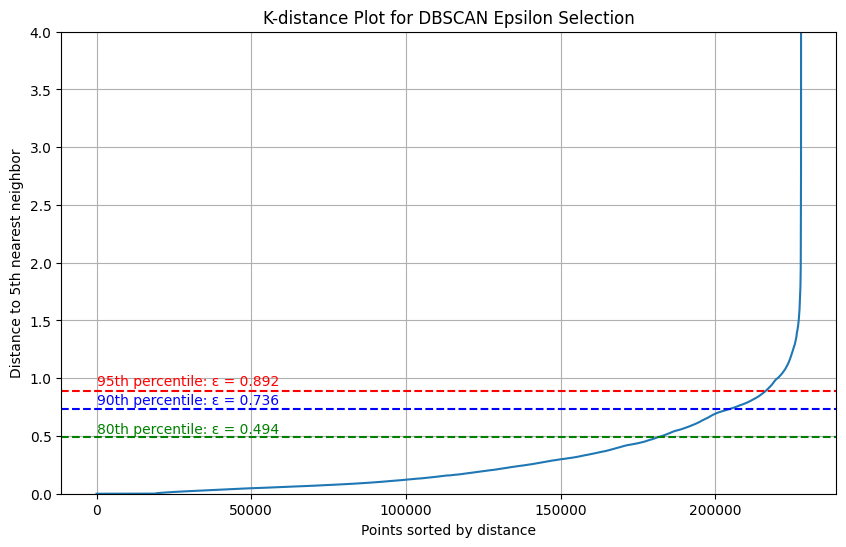

Suggested epsilon values:
- 80th percentile: 0.4938
- 90th percentile: 0.7359
- 95th percentile: 0.8917


In [10]:
# Plot with percentile markers
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.title('K-distance Plot for DBSCAN Epsilon Selection')
plt.ylim(0, 4)
plt.grid(True)

# Add horizontal lines for potential epsilon values
percentiles = [80, 90, 95]
colors = ['g', 'b', 'r']
for p, c in zip(percentiles, colors):
    y_value = np.percentile(distances, p)
    plt.axhline(y=y_value, color=c, linestyle='--')
    plt.text(0, y_value*1.05, f'{p}th percentile: ε = {y_value:.3f}', color=c)

plt.show()

print("Suggested epsilon values:")
for p in [80, 90, 95]:
    print(f"- {p}th percentile: {np.percentile(distances, p):.4f}")

In [ ]:
# 4. Test multiple epsilon values
epsilon_candidates = [
    np.percentile(distances, 80),
    np.percentile(distances, 90),
    np.percentile(distances, 95)
]

results = []
min_samples = 5

for eps in epsilon_candidates:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df_pca)  # Use reduced dimensions

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_ratio = 100 * n_noise / len(df_pca)

    results.append({
        'epsilon': eps,
        'num_clusters': n_clusters,
        'noise_points': n_noise,
        'noise_percentage': noise_ratio
    })

    print(f"Epsilon = {eps:.4f}:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Number of noise points: {n_noise}")
    print(f"  Percentage of noise: {noise_ratio:.2f}%")

    # If we have more than 1 cluster, calculate silhouette score
    if n_clusters > 1 and n_noise < len(df_pca):
        # Filter out noise points
        mask = labels != -1
        silhouette_avg = silhouette_score(df_pca[mask], labels[mask])
        print(f"  Silhouette Score: {silhouette_avg:.3f}")
    print()

Epsilon = 0.4938:
  Number of clusters: 3878
  Number of noise points: 37412
  Percentage of noise: 16.43%
  Silhouette Score: -0.031

Epsilon = 0.7359:
  Number of clusters: 1773
  Number of noise points: 16761
  Percentage of noise: 7.36%
  Silhouette Score: -0.223

Epsilon = 0.8917:
  Number of clusters: 839
  Number of noise points: 7840
  Percentage of noise: 3.44%
  Silhouette Score: -0.256



In [24]:
# 6. Choose the best epsilon and visualize results
# Replace with your chosen epsilon from the analysis above
best_epsilon = 0.4938
dbscan = DBSCAN(eps=best_epsilon, min_samples=min_samples)
df['cluster'] = dbscan.fit_predict(df_pca)

# For visualization, use the first 2 PCA components
vis_pca = PCA(n_components=2).fit_transform(df.drop('cluster', axis=1))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(vis_pca[:, 0], vis_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.title(f'DBSCAN Clustering Results (ε={best_epsilon:.4f}, min_samples={min_samples})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# 7. Analyze clusters
n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
n_noise = list(df['cluster']).count(-1)

print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise} ({100 * n_noise / len(df):.2f}%)')

<IPython.core.display.Javascript object>

Number of clusters: 3880
Number of noise points: 37406 (16.43%)


In [ ]:
# 3D visualization of clustering results using PCA
from mpl_toolkits.mplot3d import Axes3D

# Use the first 3 PCA components for 3D visualization
vis_pca_3d = PCA(n_components=3).fit_transform(df.drop('cluster', axis=1))

# Create 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with color based on cluster
scatter = ax.scatter(
    vis_pca_3d[:, 0],
    vis_pca_3d[:, 1],
    vis_pca_3d[:, 2],
    c=df['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=5  # Smaller point size for better visibility
)

# Add a color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7)
cbar.set_label('Cluster')

# Set labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title(f'3D DBSCAN Clustering (ε={best_epsilon:.4f}, min_samples={min_samples})')

# Improve perspective
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Print cluster info again for reference
print(f'Number of clusters in 3D visualization: {n_clusters}')
print(f'Number of noise points: {n_noise} ({100 * n_noise / len(df):.2f}%)')

<IPython.core.display.Javascript object>

Number of clusters in 3D visualization: 3880
Number of noise points: 37406 (16.43%)
